# 14. 데이터 불균형

데이터 불균형이란 데이터 세트 내의 클래스의 분포가 불균형한 것을 의미한다. 데이터 불균형은 특정 클래스에 과적합 되는 현상을 유발할 수 있기 때문에 반드시 해결해야 하는 문제다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd/content/gdrive/My Drive/deeplearningbro/pytorch

## 14.1 Weighted Random Sampling


In [ ]:
# 각 클래스의 비율을 정하여 뽑힐 확률에 대한 가중치를 산정한다.
import torch
from torch.utils.data import DataLoader
import torchvision
import numpy as np

def make_weights_for_balanced_classes(img, nclasses):

    labels = []
    for i in range(len(img)):
        labels.append(img[i][1])

    label_array = np.array(labels)
    total = len(labels)

    count_list = []
    for cls in range(nclasses):
        count = len(np.where(label_array == cls)[0])
        count_list.append(total/count)

    weights = []
    for label in label_array:
        weights.append(count_list[label])

    return weights


In [ ]:
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf) # 데이터 세트 불러오기

weights = make_weights_for_balanced_classes(trainset.imgs, len(trainset.classes)) # 가중치 계산
weights = torch.DoubleTensor(weights) # 텐서 변환
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 샘플링 방법 정의

trainloader = DataLoader(trainset, batch_size=16, sampler=sampler) # 데이터 로더 정의

##14.2 Weighted Loss Function

In [ ]:
import torch.nn as nn
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_ins = [40,45,30,62,70,153,395,46,75,194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## 14.3 Data Augmentation

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose(
                [tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                 tr.RandomHorizontalFlip(),
                 tr.RandomRotation(10, resample=PIL.Image.BILINEAR),
                 tr.ToTensor()
                 ])

## 14.4 Confusion Matrix

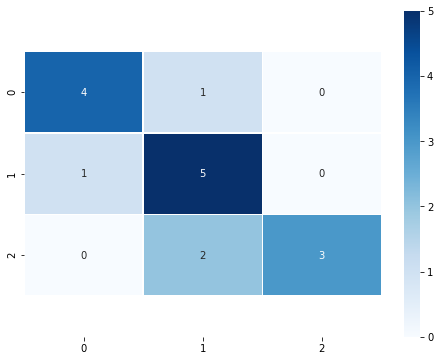

In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1,1,1,1,1,1,0,0,0,0,0,2,2,2,2,2]
prediction = [1,1,1,0,1,1,0,0,0,1,0,2,2,2,1,1]
c_mat = confusion_matrix(actual, prediction) # 실제 라벨, 예측값
plt.figure(figsize = (8,6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues',linewidths=.5)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.savefig('confusion_matrix.png')
plt.show()

